In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os


In [2]:
DATA_CSV = '../data/raw_dataset.csv'
df = pd.read_csv(DATA_CSV)

print('✅ Dataset loaded successfully.')
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())
print('Missing values per column:\n', df.isna().sum())

df.head()


✅ Dataset loaded successfully.
Shape: (24683, 9)
Columns: ['Country', 'Year', 'Crop', 'Area', 'Production', 'Yield', 'Rainfall_mm', 'Temperature_C', 'Pesticide_Use']
Missing values per column:
 Country          0
Year             0
Crop             0
Area             0
Production       0
Yield            0
Rainfall_mm      0
Temperature_C    0
Pesticide_Use    0
dtype: int64


,Country,Year,Crop,Area,Production,Yield,Rainfall_mm,Temperature_C,Pesticide_Use
0,Albania,1990,Maize,36613,1485.0,16.37,1485.0,16.37,121.0
1,Albania,1991,Maize,29068,1485.0,15.36,1485.0,15.36,121.0
2,Albania,1992,Maize,24876,1485.0,16.06,1485.0,16.06,121.0
3,Albania,1993,Maize,24185,1485.0,16.05,1485.0,16.05,121.0
4,Albania,1994,Maize,25848,1485.0,16.96,1485.0,16.96,201.0


In [3]:
X = df[['Rainfall_mm', 'Temperature_C', 'Pesticide_Use', 'Area', 'Production']].values
y = df['Yield'].values.reshape(-1, 1)

print('X Shape:', X.shape)
print('y Shape:', y.shape)


X Shape: (24683, 5)
y Shape: (24683, 1)


In [4]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

print('Original features:', X.shape[1])
print('Polynomial features:', X_poly.shape[1])
print('Feature names:', poly.get_feature_names_out(['Rain', 'Temp', 'Pest', 'Area', 'Prod']))


Original features: 5
Polynomial features: 20
Feature names: ['Rain' 'Temp' 'Pest' 'Area' 'Prod' 'Rain^2' 'Rain Temp' 'Rain Pest'
 'Rain Area' 'Rain Prod' 'Temp^2' 'Temp Pest' 'Temp Area' 'Temp Prod'
 'Pest^2' 'Pest Area' 'Pest Prod' 'Area^2' 'Area Prod' 'Prod^2']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Add bias column
X_train_b = np.hstack([np.ones((X_train_s.shape[0], 1)), X_train_s])
X_test_b = np.hstack([np.ones((X_test_s.shape[0], 1)), X_test_s])

print('Train X:', X_train_b.shape, 'Train y:', y_train.shape)
print('Test X:', X_test_b.shape, 'Test y:', y_test.shape)


Train X: (17278, 21) Train y: (17278, 1)
Test X: (7405, 21) Test y: (7405, 1)


In [9]:
def train_advanced(X, y, lr=0.01, iters=8000, lambda_reg=0.001, beta=0.9):
    m, n = X.shape
    theta = np.zeros((n, 1))
    v = np.zeros((n, 1))
    cost_hist = []
    best_cost = float('inf')
    patience = 200
    wait = 0
    
    for i in range(iters):
        preds = X.dot(theta)
        error = preds - y
        grad = (1/m)*X.T.dot(error) + (lambda_reg/m)*theta
        grad[0] -= (lambda_reg/m)*theta[0]  # do not regularize bias
        v = beta*v + (1-beta)*grad
        theta -= lr*v
        
        cost = (1/(2*m))*np.sum(error**2) + (lambda_reg/(2*m))*np.sum(theta[1:]**2)
        cost_hist.append(cost)
        
        if cost < best_cost:
            best_cost = cost
            best_theta = theta.copy()
            wait = 0
        else:
            wait += 1
        
        if wait >= patience:
            print(f"Early stopping at iteration {i}")
            break
    return best_theta, cost_hist


In [8]:
MODEL_FILE = '../models/theta_model.npy'

if os.path.exists(MODEL_FILE):
    theta = np.load(MODEL_FILE)
    print("✅ Loaded pre-trained theta_model.npy")
else:
    theta, costs = train_advanced(X_train_b, y_train)
    np.save(MODEL_FILE, theta)
    print("✅ Training complete and model saved")


✅ Loaded pre-trained theta_model.npy


Test MSE: 5.879701925463809
R² Score: 0.8069760344252026


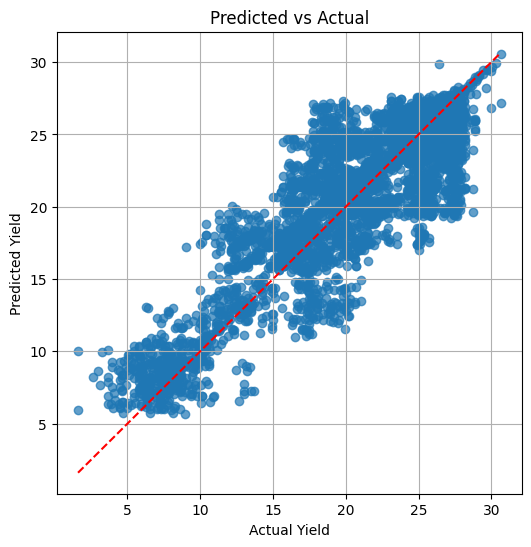

In [10]:
y_pred = X_test_b.dot(theta)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Test MSE:', mse)
print('R² Score:', r2)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()


In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.savefig('../images/chart1.png')  # For README
plt.close()
